In [50]:
import os
import gc
import time
import json
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib


In [51]:
with open('./env/settings.json') as f:
  path_file = json.load(f)

TRAIN_PROCESSED_DATA_PATH = path_file['TRAIN_PROCESSED_DATA_PATH']
TEST_PROCESSED_DATA_PATH = path_file['TEST_PROCESSED_DATA_PATH']

PROCESSED_DATA_DIR = path_file["PROCESSED_DATA_DIR"]
SUBMISSION_DIR = path_file["SUBMISSION_DIR"]

OUTPUT_DIR = path_file["OUTPUT_DIR"]

In [52]:
TARGET_COL="取引価格（総額）_log"
ID_COL="ID"
RANDOM_STATE=42

In [53]:
import random
import numpy as np
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [54]:
train_df = pd.read_csv(TRAIN_PROCESSED_DATA_PATH)
test_df = pd.read_csv(TEST_PROCESSED_DATA_PATH)

In [55]:
qualitative = [f for f in train_df.columns if train_df[f].dtype == "object"]

for col in qualitative:
  train_df[col] = train_df[col].astype('category')
  test_df[col] = test_df[col].astype('category')

In [56]:
del_col  = [TARGET_COL,"ID"]
y_train = train_df[TARGET_COL]

In [57]:
test_df.head(3)

,ID,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log
0,1000000,1101,北海道,札幌市中央区,旭ケ丘,円山公園,26.0,３ＬＤＫ,75.0,1989.0,ＲＣ,NaN,住宅,第１種低層住居専用地域,40.0,60.0,2020年第２四半期,未改装,NaN
1,1000056,1101,北海道,札幌市中央区,大通西,西１１丁目,1.0,２ＬＤＫ,55.0,2016.0,ＲＣ,NaN,住宅,商業地域,80.0,600.0,2020年第１四半期,未改装,NaN
2,1000108,1101,北海道,札幌市中央区,大通西,西１８丁目,2.0,１Ｒ,15.0,1989.0,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2020年第２四半期,未改装,NaN


In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train,X_test,y_train,y_test = train_test_split(train_df.drop(del_col,axis=1),y_train,test_size=0.25,shuffle=True,random_state=RANDOM_STATE)

In [60]:
feature_selection_params = {
    "objective": "mae",                # 目的関数
    "learning_rate": 0.01,             # 学習率 
    "reg_lambda": 1.0,                 # L2正則化項
    "reg_alpha": 0.1,                  # L1正則化項
    "max_depth": 10,                   # 決定木の深さ
    "n_estimators": 2500,              # 決定木の数
    "colsample_bytree": .5,            # 各木を作成するときに使用可能な特徴量の割合
    "min_child_samples": 10,           # 末端ノードに含まれる最小のデータ数
    "subsample": .9,                   # 各ツリーで選択されるサンプリングの割合
    "subsample_freq": 3,               # サンプリングの頻度
    "importance_type": "gain",         # 重要度の種類を指定 split:特徴がモデルで何回使われたか, gain:徴を利用した分割の総獲得数
    "random_state": RANDOM_STATE,      # 乱数シード
    "n_jobs":-1,                       # 並列処理
    "device":"cpu",                    # デバイス設定、GPU環境なら "gpu"を指定
    "max_bin":100,                     # 一つの分岐に入るデータ数の最大値
}

set_seed(RANDOM_STATE)
model=lgb.LGBMRegressor(**feature_selection_params)
model.fit(X_train, y_train,
            eval_set=[(X_test,y_test)],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=800,verbose=True),lgb.log_evaluation(0)]
            )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11958
[LightGBM] [Info] Number of data points in the train set: 478013, number of used features: 17
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.255272
Training until validation scores

LGBMRegressor(colsample_bytree=0.5, device='cpu', importance_type='gain',
              learning_rate=0.01, max_bin=100, max_depth=10,
              min_child_samples=10, n_estimators=2500, n_jobs=-1,
              objective='mae', random_state=42, reg_alpha=0.1, reg_lambda=1.0,
              subsample=0.9, subsample_freq=3)

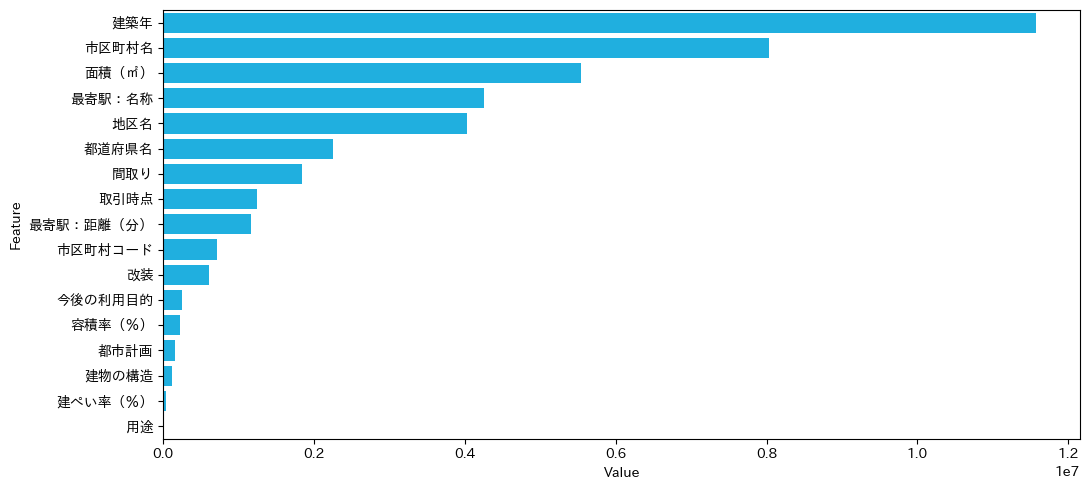

In [61]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)),columns=['Value','Feature'])
plt.figure(figsize=(11,5))
sns.barplot(data=feature_imp.sort_values(by='Value',ascending=False),x='Value',y="Feature",color='deepskyblue')
plt.tight_layout()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error

In [63]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.07868793562121934

In [70]:
test_df[TARGET_COL] = model.predict(test_df.drop([TARGET_COL,"ID"], axis=1))
# test_df[TARGET_COL] = model.predict(test_df.drop("ID",axis=1))

submission = pd.read_csv(SUBMISSION_DIR)
submission[TARGET_COL] = test_df[TARGET_COL]
submission = pd.merge(submission["ID"],test_df[["ID",TARGET_COL]],on="ID")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [73]:
exp_name = "lightgbm_baseline"

import pytz
import datetime
now = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y-%m-%d-%H-%M-%S')
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

submission.to_csv(f"{OUTPUT_DIR}submission_{exp_name}_{now}.csv", index=False)